# Исследование для интернет магазина "В один клик"

**Цель исследования** - разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.


**Задачи исследования**

* Нужно промаркировать уровень финансовой активности постоянных покупателей. 
* Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
* В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.
* Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.

**План исследования**

1. **Загрузка данных.** Загрузить данные и убедиться в наличии всех признаков указанных в задании.
2. **Предобработка данных.** Провести предобработку данных.
3. **Исследовательский анализ данных.** Проведите исследовательский анализ данных из каждой таблицы. Отберите клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период. 
4. **Объеденить данные таблиц.** Учесть, что данные о выручке и времени на сайте находятся в одном столбце для всех периодов. В итоговой таблице сделать отдельный столбец для каждого периода.
5. Провести корреляционный анализ признаков в количественной шкале в итоговой таблице для моделирования. Сделайть выводы о мультиколлинеарности и при необходимости устранить её.
6. **Использование пайплайнов.** Подготовить пайплайн для обработки данных и обучения данных на различных моделях. Выбрать лучшую модель и лучшие гиперпараметры. 
7. **Анализ важности признаков.** Оцените важность признаков для лучшей модели и постройте график важности с помощью метода SHAP. 
8. **Сегментация покупателей.** Выполнить сегментацию покупателей. Выбрать группу покупателей и предложить решение для увеличения покупательской способности группы.
9. Написать общий вывод по проделанной работе.

## Загрузка даных

Импортируем необходимые для работы библиотеки

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
import shap
from sklearn.metrics import roc_auc_score,accuracy_score
from sklearn.dummy import DummyClassifier
import seaborn as sns

Загрузим таблицу содержащую данные о поведении покупателей на сайте.

In [106]:
df_market_file = pd.read_csv('data/market_file.csv')

In [107]:
df_market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


Выведем общую информацию о таблице

In [108]:
df_market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

Данные таблица корректно загружены. Признаки соответсвуют описанию

Загрузим таблицу с данными о выручке магазина с покупателя в определённый период.

In [109]:
df_market_money = pd.read_csv('data/market_money.csv')

In [110]:
df_market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


Выведем общую информацию о таблице

In [111]:
df_market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


Данные таблица корректно загружены. Признаки соответсвуют описанию

Загрузим таблицу содержащую информацию о времени, которое пользователь провел на сайте.

In [112]:
df_market_time = pd.read_csv('data/market_time.csv')

In [113]:
df_market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


Выведем общую информацию о таблице

In [114]:
df_market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


Данные таблица корректно загружены. Признаки соответсвуют описанию

Загрузим таблицу с данными о среднемесячной прибыли с покупателя за последние три месяца

In [115]:
df_money = pd.read_csv('data/money.csv',sep=';',decimal=',') 

In [116]:
df_money.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


Выведем информацию о таблице

In [117]:
df_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


Данные таблица корректно загружены. Признаки соответсвуют описанию

**Вывод**

Данные всех таблиц успешно загружены. Все признаки в таблицах соответствуют описанию

## Предобработка данных

### Предобработка данных о поведении покупателей на сайте

In [118]:
df_market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


**Анализ таблицы на наличие пропусков**

In [119]:
df_market_file.isna().sum()

id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64

В данных отсутствуют пропуски

**Анализ таблицы на дубликаты**

In [120]:
df_market_file.duplicated().sum()

0

В данных отсутствуют дубликаты

**Анализ таблицы на наличие неявных дубликатов**

Проанализируем категориальные столбцы на наличие неявных дубликатов

In [121]:
for column in ['Покупательская активность','Тип сервиса','Разрешить сообщать','Популярная_категория']:
    print(f'Уникальные значения в столбце {column}: {df_market_file[column].unique()}')

Уникальные значения в столбце Покупательская активность: ['Снизилась' 'Прежний уровень']
Уникальные значения в столбце Тип сервиса: ['премиум' 'стандартт' 'стандарт']
Уникальные значения в столбце Разрешить сообщать: ['да' 'нет']
Уникальные значения в столбце Популярная_категория: ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


В столбце с типом сервиса есть неявный дубликат устраним его.

In [122]:
df_market_file['Тип сервиса'] = df_market_file['Тип сервиса'].replace('стандартт','стандарт')


Исправим название популярной категории


In [123]:
df_market_file['Популярная_категория'] = df_market_file['Популярная_категория'].replace('Косметика и аксесуары','Косметика и аксессуары')

In [124]:
df_market_file['Популярная_категория'].unique()

array(['Товары для детей', 'Домашний текстиль', 'Косметика и аксессуары',
       'Техника для красоты и здоровья', 'Кухонная посуда',
       'Мелкая бытовая техника и электроника'], dtype=object)

In [125]:
df_market_file['Тип сервиса'].unique()

array(['премиум', 'стандарт'], dtype=object)

Неявные дубликаты устранены 

В качестве индексов таблицы установим id клиента

In [126]:
df_market_file = df_market_file.set_index('id') 

In [127]:
df_market_file.head()

,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
id,,,,,,,,,,,,
215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


**Приведение данных к корректному типу**

Приведём столбцы с целочисленными данными к корректному типу данный для экономии памяти.

In [128]:
df_market_file['Маркет_актив_тек_мес'] = df_market_file['Маркет_актив_тек_мес'].astype('int8')
df_market_file['Средний_просмотр_категорий_за_визит'] = df_market_file['Средний_просмотр_категорий_за_визит'].astype('int8')
df_market_file['Неоплаченные_продукты_штук_квартал'] = df_market_file['Неоплаченные_продукты_штук_квартал'].astype('int8')
df_market_file['Ошибка_сервиса'] = df_market_file['Ошибка_сервиса'].astype('int8')
df_market_file['Страниц_за_визит'] = df_market_file['Страниц_за_визит'].astype('int8')
df_market_file['Длительность'] = df_market_file['Длительность'].astype('int16')

In [129]:
df_market_file.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1300 entries, 215348 to 216647
Data columns (total 12 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Покупательская активность            1300 non-null   object 
 1   Тип сервиса                          1300 non-null   object 
 2   Разрешить сообщать                   1300 non-null   object 
 3   Маркет_актив_6_мес                   1300 non-null   float64
 4   Маркет_актив_тек_мес                 1300 non-null   int8   
 5   Длительность                         1300 non-null   int16  
 6   Акционные_покупки                    1300 non-null   float64
 7   Популярная_категория                 1300 non-null   object 
 8   Средний_просмотр_категорий_за_визит  1300 non-null   int8   
 9   Неоплаченные_продукты_штук_квартал   1300 non-null   int8   
 10  Ошибка_сервиса                       1300 non-null   int8   
 11  Страниц_за_визит            

Теперь столбцы с целочисленными данными занимают меньше места

### Предобработка данных о выручке

In [130]:
df_market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


**Анализ таблицы на наличие пропусков**

In [131]:
df_market_money.isna().sum()

id         0
Период     0
Выручка    0
dtype: int64

В таблице отсутствуют пропуски

**Анализ таблицы на дубликаты**

In [132]:
df_market_money.duplicated().sum()

0

В таблице отсутствуют дубликаты

**Анализ таблицы на наличие неявных дубликатов**

Проанализируем категориальные столбцы на наличие неявных дубликатов

In [133]:
df_market_money['Период'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

Неявные дубликаты отсутсвуют. Заменим категорию 'препредыдущий_месяц' на 'предпредыдущий_месяц'

In [134]:
df_market_money = df_market_money.replace('препредыдущий_месяц', 'предпредыдущий_месяц')

In [135]:
df_market_money['Период'].unique()

array(['предпредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

### Предобработка данных о времени

In [136]:
df_market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


**Анализ таблицы на наличие пропусков**

In [137]:
df_market_time.isna().sum()

id        0
Период    0
минут     0
dtype: int64

В данных отсутствуют пропуски

**Анализ таблицы на дубликаты**

In [138]:
df_market_time.duplicated().sum()

0

В данных отсутствуют дубликаты

**Анализ таблицы на неявные дубликаты**

In [139]:
df_market_time['Период'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

В данных отсутствуют неявыне дубликаты. Исправим ошибку в категории.

In [140]:
df_market_time = df_market_time.replace('предыдцщий_месяц', 'предыдущий_месяц')
df_market_time['Период'].unique()

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

### Предобработка данных о среднемесячной прибыли от покупателя

In [141]:
df_money.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


**Анализ таблицы на наличие пропусков**

In [142]:
df_money.isna().sum()

id         0
Прибыль    0
dtype: int64

В таблице отсутствуют пропуски

**Анализ таблицы на дубликаты**

In [143]:
df_money.duplicated().sum()

0

В таблице отсутствуют дубликаты

Установим в качестве индекса id покупателя

In [144]:
df_money = df_money.set_index('id') 

In [145]:
df_money.head()

,Прибыль
id,
215348,0.98
215349,4.16
215350,3.13
215351,4.87
215352,4.21


**Вывод**

* В ходе предобработки данных из таблицы были проверены на наличие пропусков, дубликатов, неявных дубликатов. Были исправлены ошибки в данных, некоторые столбцы были приведены к корректному типу

## Исследовательский анализ данных

### Исследовательский анализ данных таблицы о поведении покупателей на сайте

In [146]:
df_market_file.head()

,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
id,,,,,,,,,,,,
215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


Проанализирум признаки требующие построения гистограммы для анализа

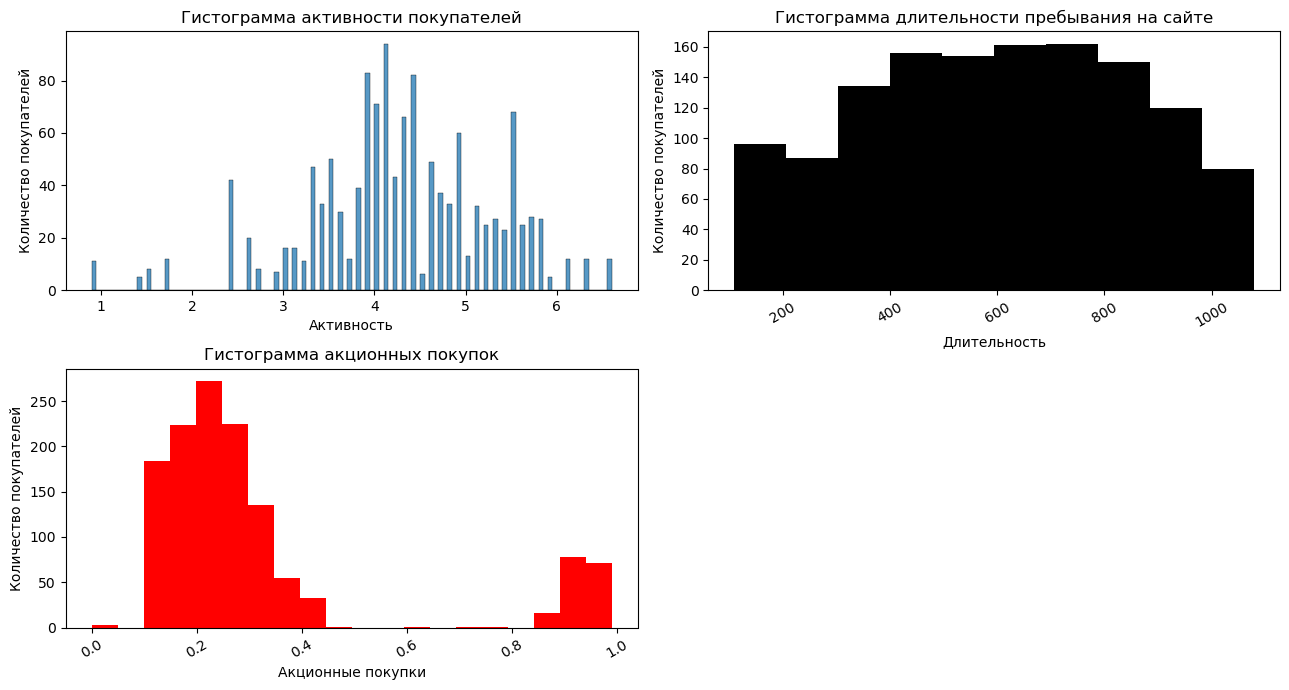

In [147]:
fig, ax = plt.subplots(2, 2, figsize=(13, 7))  # создаём 2x2 сетку

sns.histplot(df_market_file['Маркет_актив_6_мес'], binwidth=0.05, ax=ax[0, 0])
ax[0, 0].set_xlabel('Активность')
ax[0, 0].set_ylabel('Количество покупателей')
ax[0, 0].set_title('Гистограмма активности покупателей')

df_market_file['Длительность'].plot.hist(rot=30, color='k', bins=10, ax=ax[0, 1])
ax[0, 1].set_xlabel('Длительность')
ax[0, 1].set_ylabel('Количество покупателей')
ax[0, 1].set_title('Гистограмма длительности пребывания на сайте')

df_market_file['Акционные_покупки'].plot.hist(rot=30, color='r', bins=20, ax=ax[1, 0])
ax[1, 0].set_xlabel('Акционные покупки')
ax[1, 0].set_ylabel('Количество покупателей')
ax[1, 0].set_title('Гистограмма акционных покупок')

fig.delaxes(ax[1, 1]) 

plt.tight_layout()
plt.show()

* Гистограмма активности пользователей представляет собой унимодальное распределение похожее на нормальное
* Гистограмма длительности пребывания пользователей представляет собой унимодальное распределение похожее на нормальное
* Гистограмма акционных покупок пользователей представляет собой бимодальное с двумя ярковыраженными пиками. Возможно, этот признак должен быть преобразован в категориальный.

Проанализируем категориальные признаки содержащие более трех категорий

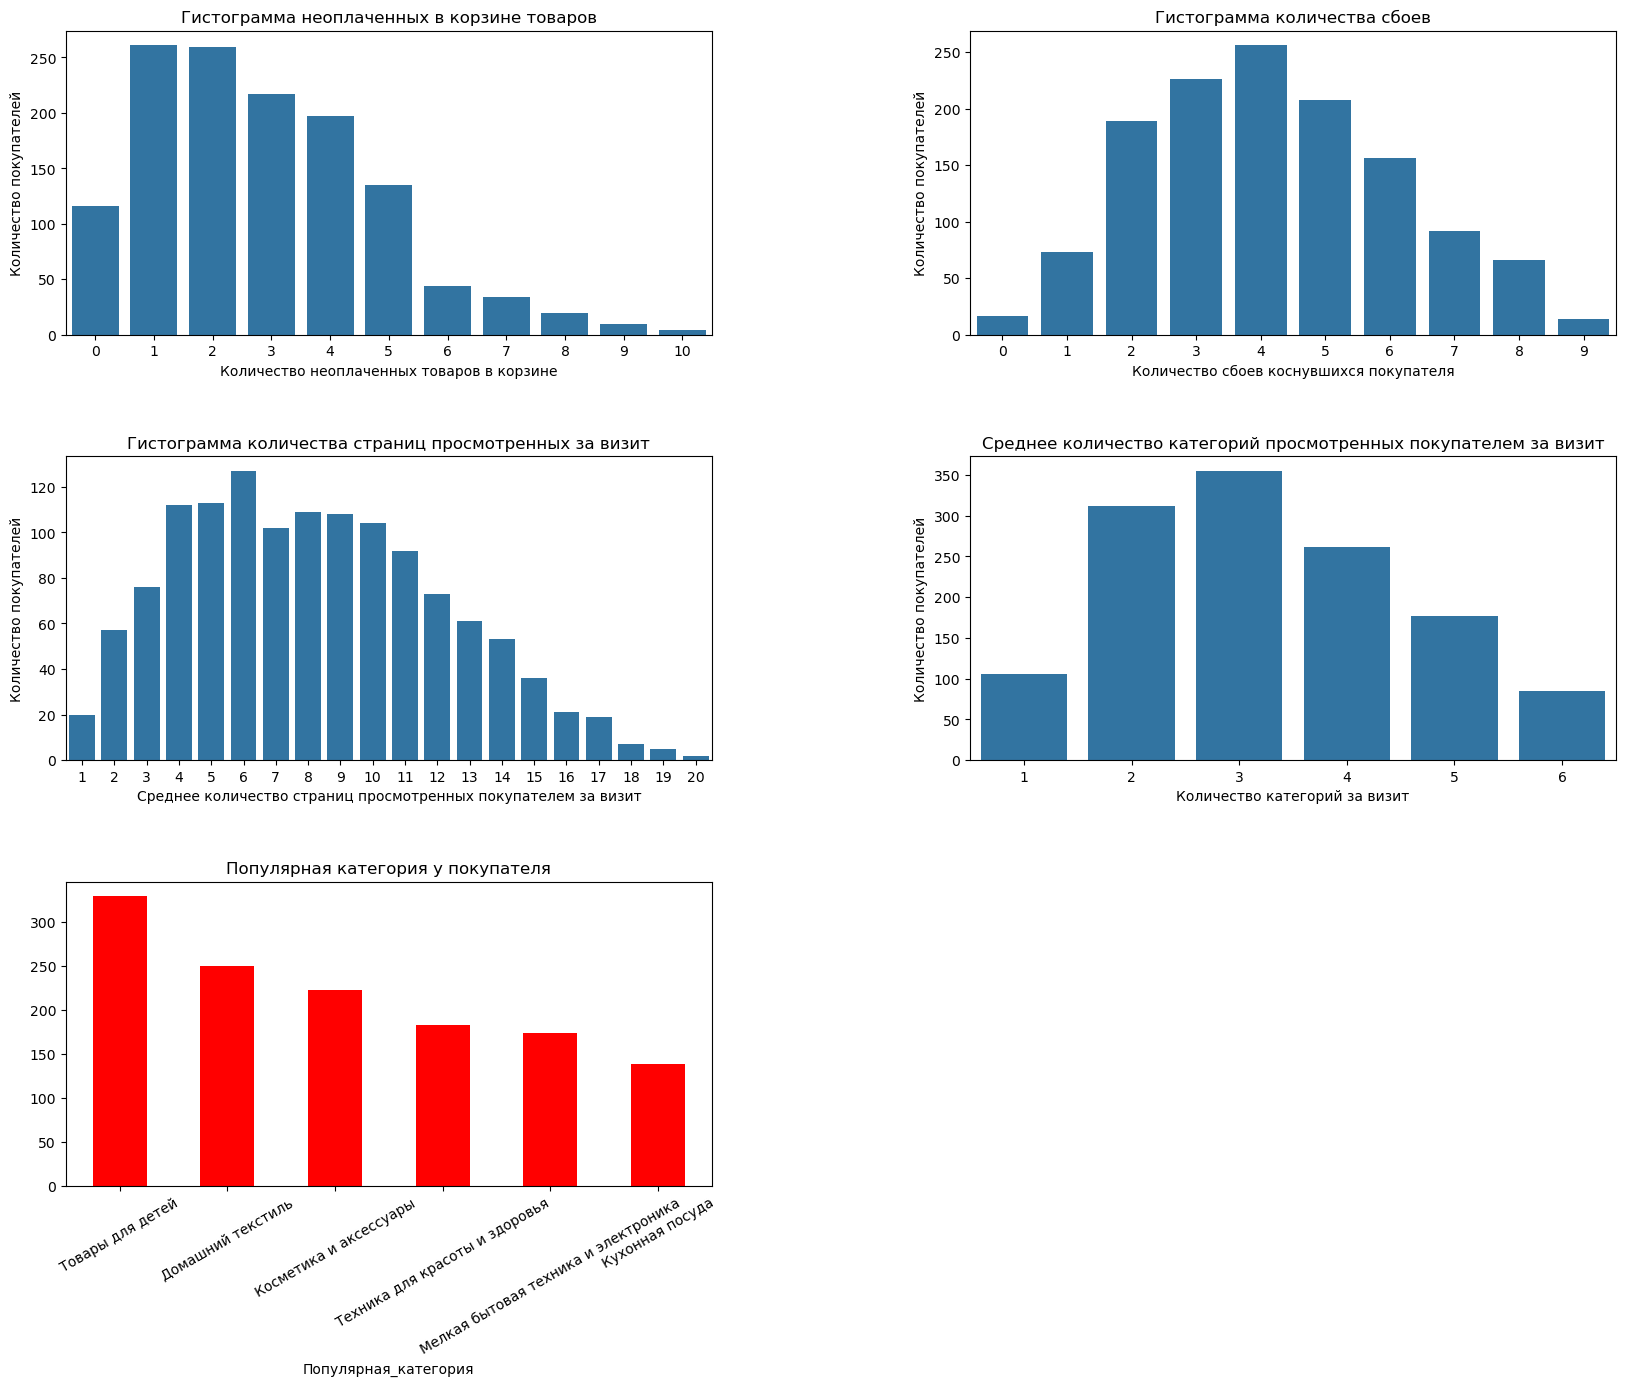

In [206]:
fig, ax = plt.subplots(3, 2, figsize=(20, 15))

pop_category = df_market_file['Популярная_категория'].value_counts()

sns.countplot(data=df_market_file, x="Неоплаченные_продукты_штук_квартал",ax=ax[0,0])
ax[0,0].set_xlabel('Количество неоплаченных товаров в корзине')
ax[0,0].set_ylabel('Количество покупателей')
ax[0,0].set_title('Гистограмма неоплаченных в корзине товаров')
plt.subplots_adjust(wspace=0.4, hspace=0.4)


sns.countplot(data=df_market_file, x='Страниц_за_визит',ax=ax[1,0])
ax[1,0].set_xlabel('Среднее количество страниц просмотренных покупателем за визит')
ax[1,0].set_ylabel('Количество покупателей')
ax[1,0].set_title('Гистограмма количества страниц просмотренных за визит')
plt.subplots_adjust(wspace=0.4, hspace=0.4)

sns.countplot(data=df_market_file, x='Ошибка_сервиса',ax=ax[0,1])
ax[0,1].set_xlabel('Количество сбоев коснувшихся покупателя')
ax[0,1].set_ylabel('Количество покупателей')
ax[0,1].set_title('Гистограмма количества сбоев')
plt.subplots_adjust(wspace=0.4, hspace=0.4)

sns.countplot(data=df_market_file,x='Средний_просмотр_категорий_за_визит',ax=ax[1,1])
ax[1,1].set_xlabel('Количество категорий за визит')
ax[1,1].set_ylabel('Количество покупателей')
ax[1,1].set_title('Среднее количество категорий просмотренных покупателем за визит')
plt.subplots_adjust(wspace=0.4, hspace=0.4)

pop_category.plot.bar(rot=30,color='r',ax=ax[2,0])
plt.ylabel('Количество покупателей')
ax[2,0].set_title('Популярная категория у покупателя')

plt.subplots_adjust(wspace=0.4, hspace=0.4)

ax[2, 1].set_axis_off()

* Гистограмма неоплаченных в корзине товаров представляет собой унимодальное распределение похожее на  пуассоновское.
* Гистограмма количества страниц просмотренных за визит пользователей представляет собой унимодальное распределение похожее на нормальное
* Гистограмма количества сбоев коснувшихся пользователя представляет собой унимодальное распределение похожее на нормальное
* Среднее количество категорий просмотренных за визит - категориальный признак содержащий 6 категорий. Больше всего покупателей просматривающих три категории за визит.
* Популярная категория у покупатей  - категориальный признак содержащий шесть категорий. Наиболее популярная категория - Товары для детей.

Проанализируем категориальные признаки содержащие три и менее категорий.

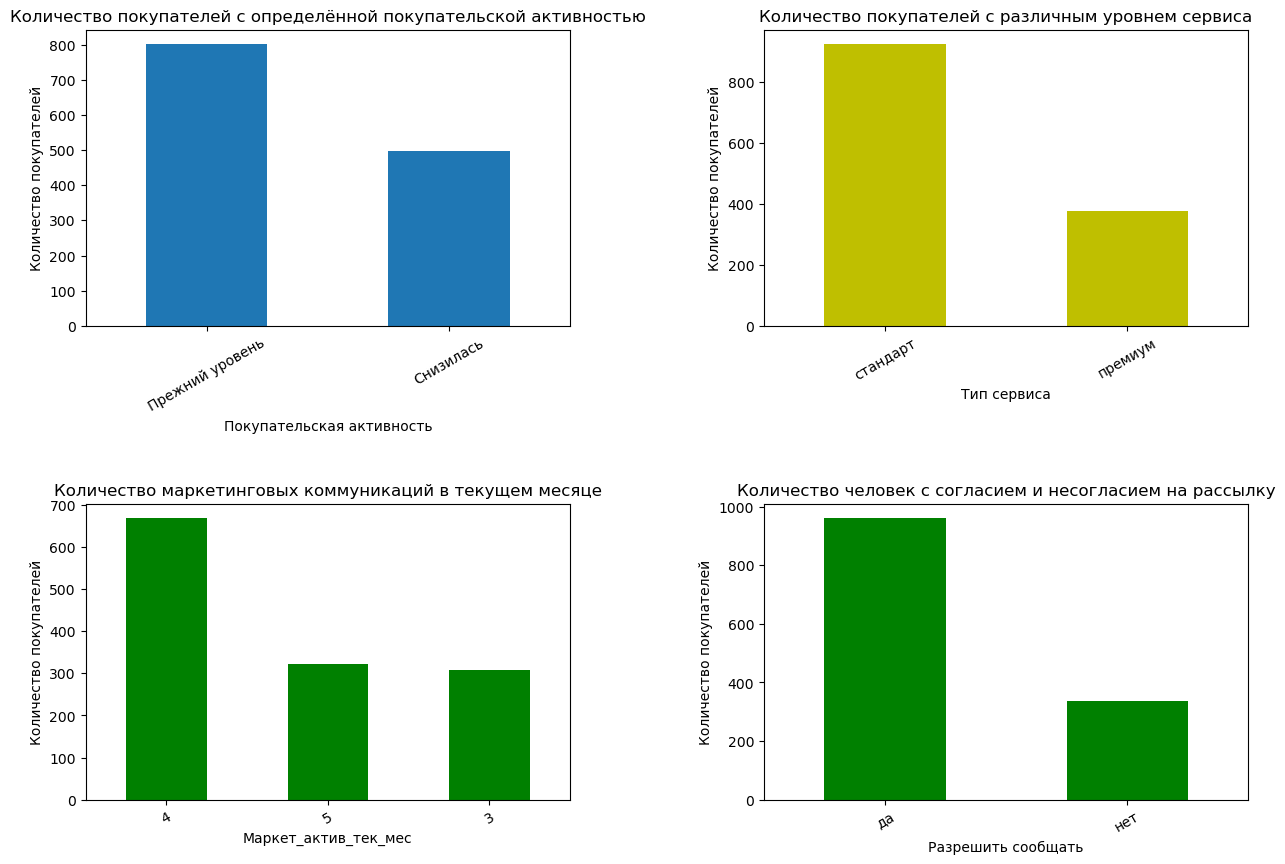

In [149]:
plt.figure(figsize=(15,10))

activities = df_market_file['Покупательская активность'].value_counts()
type_service = df_market_file['Тип сервиса'].value_counts()
act_cur_month = df_market_file['Маркет_актив_тек_мес'].value_counts()
unpaid_goods_counts = df_market_file['Неоплаченные_продукты_штук_квартал'].value_counts()
service_error = df_market_file['Ошибка_сервиса'].value_counts()
pages_per_visit = df_market_file['Страниц_за_визит'].value_counts()
agree = df_market_file['Разрешить сообщать'].value_counts()


plt.subplot(2, 2, 1)
activities.plot.bar(rot=30)
plt.ylabel('Количество покупателей')
plt.title('Количество покупателей с определённой покупательской активностью')
plt.subplots_adjust(wspace=0.4, hspace=0.4)

plt.subplot(2, 2, 2)
type_service.plot.bar(rot=30, color='y')
plt.ylabel('Количество покупателей')
plt.title('Количество покупателей с различным уровнем сервиса')
plt.subplots_adjust(wspace=0.4, hspace=0.4)

plt.subplot(2, 2, 3)
act_cur_month.plot.bar(rot=30,color='g')
plt.ylabel('Количество покупателей')
plt.title('Количество маркетинговых коммуникаций в текущем месяце')
plt.subplots_adjust(wspace=0.4, hspace=0.4)

plt.subplot(2, 2, 4)
agree.plot.bar(rot=30,color='g')
plt.ylabel('Количество покупателей')
plt.title('Количество человек с согласием и несогласием на рассылку')
plt.subplots_adjust(wspace=0.4, hspace=0.6)

* Уровень покупательской активности - целевой признак. Наблюдается дисбаланс классов.
* Количество покупателей с уровнем сервиса "премиум" намного меньше по сравнению с количеством покупателей с уровнем сервиса 'стандарт'
* Количество маркетенговых коммуникаций - категориальный признак содержащий три категории. Больше всего покупателей с уровнем маркетенговых коммуникаций - 4.
* Согласие на рассылку дали большинство пользователей.

### Исследовательский анализ данных о выручке

In [150]:
df_market_money.head()

,id,Период,Выручка
0,215348,предпредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,предпредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


Оценим суммарную выручку за различные месяца.

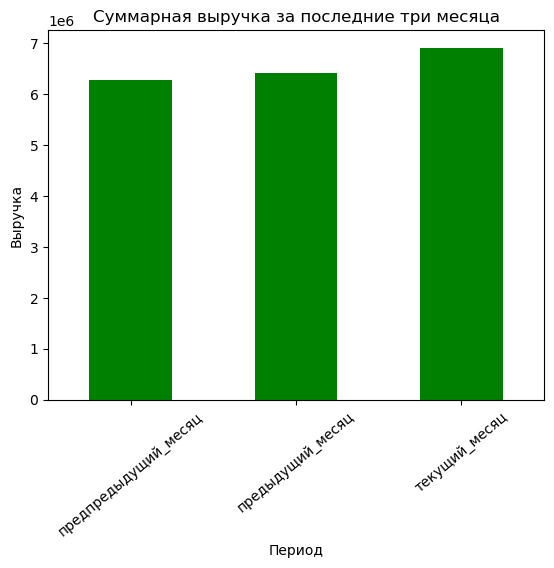

In [151]:
df_market_money.groupby('Период')['Выручка'].agg('sum').plot.bar(rot=40,color='g')
plt.title('Суммарная выручка за последние три месяца')
plt.ylabel('Выручка')
plt.show()

Выручки по месяцам соизмеримы, наибольшая выручка наблюдалась в текущем месяце.

Рассмотрим суммарную выручку по пользователям

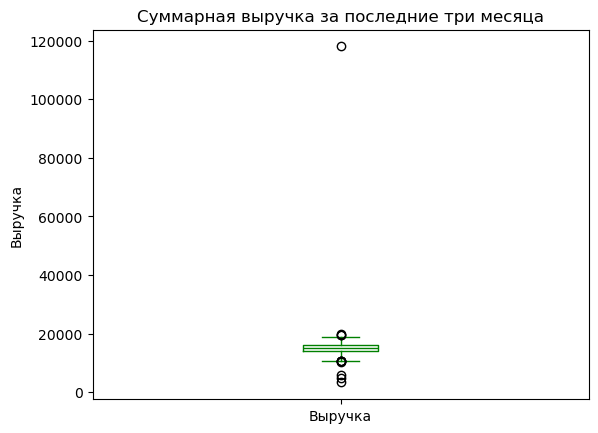

In [152]:
df_market_money.groupby('id')['Выручка'].agg('sum').plot(kind='box',color='g')
plt.title('Суммарная выручка за последние три месяца')
plt.ylabel('Выручка')
plt.show()

В данных наблюдается выброс. Найдём его

In [153]:
df_market_money.query('Выручка > 100_000')

,id,Период,Выручка
98,215380,текущий_месяц,106862.2


Либо пользователь приобрёл покупки на значительную сумму (аномальное значение), либо произошла ошибка при заполнении данных

Будем считать, что при заполнении произошла ошибка, исправим её.

In [154]:
df_market_money['Выручка'] = df_market_money['Выручка'].apply(lambda x: df_market_money['Выручка'].mean() if x > 10_000 else x)

In [155]:
df_market_money.query('Выручка > 100_000')

,id,Период,Выручка


Убедимся в отсутствии выбросов

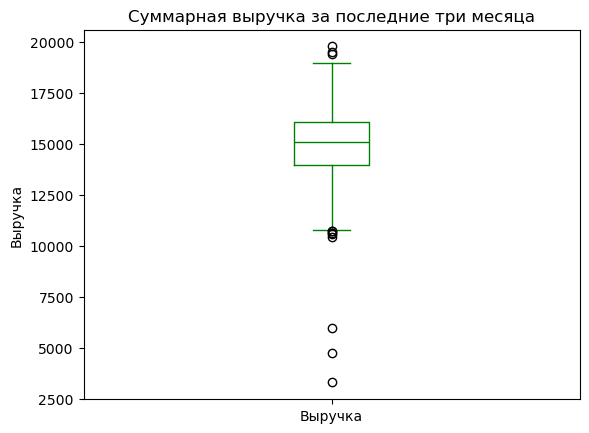

In [156]:
df_market_money.groupby('id')['Выручка'].agg('sum').plot(kind='box',color='g')
plt.title('Суммарная выручка за последние три месяца')
plt.ylabel('Выручка')
plt.show()

Найдём покупателей, которые не совершали покупок в течении последних трех месяцев

In [157]:
df_market_money.pivot_table(index='id',values='Выручка',aggfunc='sum').query('Выручка == 0')

,Выручка
id,


В данных нет покупателей, которые не совершали покупок все предшествующие месяцы.

Найдём покупателей, у которых хотя бы в один месяц была нулевая выручка

In [158]:
custom_to_drop = df_market_money.query('Выручка == 0')['id'].unique()
custom_to_drop

array([215348, 215357, 215359], dtype=int64)

In [159]:
df_market_money = df_market_money.query('id not in @custom_to_drop')

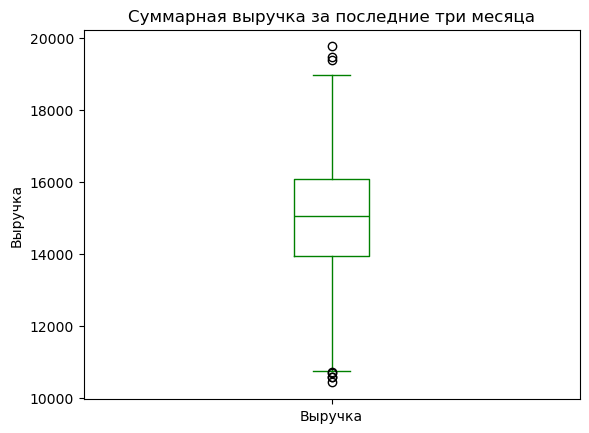

In [160]:
df_market_money.groupby('id')['Выручка'].agg('sum').plot(kind='box',color='g')
plt.title('Суммарная выручка за последние три месяца')
plt.ylabel('Выручка')
plt.show()

После удаления покупателей с нулевой выручкой за последние три мясяца, выбросы снизу были устранены

Удалим ненужные наблюдения из основного датасета

In [161]:
df_market_file = df_market_file.query('id not in @custom_to_drop')

In [162]:
df_market_file.shape

(1297, 12)

Размерность датафрейма изменилась

### Исследовательский анализ данных о времени

In [163]:
df_market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдущий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдущий_месяц,12
4,215350,текущий_месяц,13


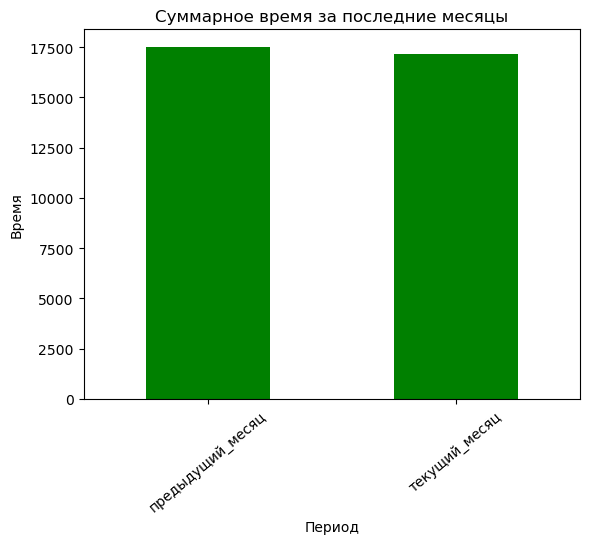

In [164]:
df_market_time.groupby('Период')['минут'].agg('sum').plot.bar(rot=40,color='g')
plt.title('Суммарное время за последние месяцы')
plt.ylabel('Время')
plt.show()

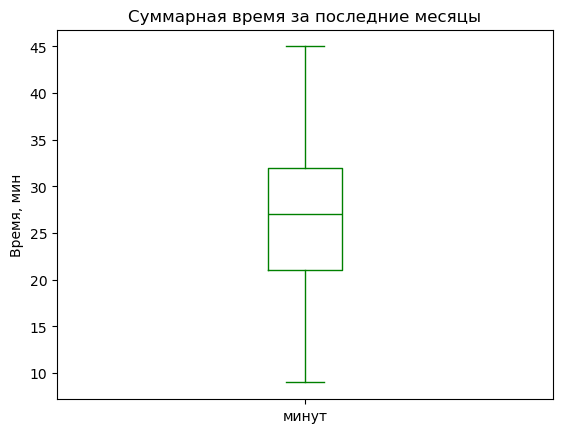

In [165]:
df_market_time.groupby('id')['минут'].agg('sum').plot(kind='box',color='g')
plt.title('Суммарная время за последние месяцы')
plt.ylabel('Время, мин')
plt.show()

Удалим из датасета ненужные наблюдения.

In [166]:
df_market_time = df_market_time.query('id not in @custom_to_drop')

In [167]:
df_market_time.shape

(2594, 3)

### Исследовательский анализ данных о среднемесячной прибыли от покупателя

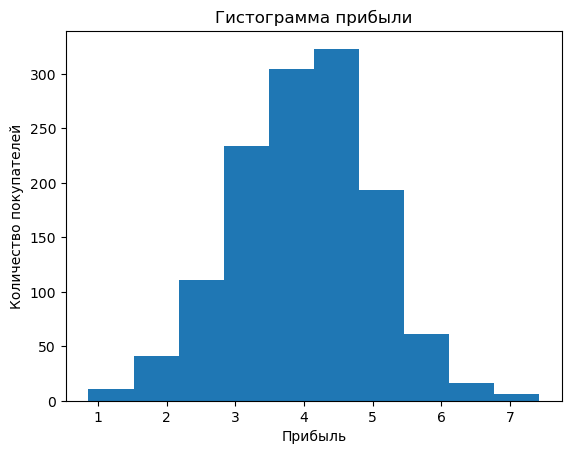

In [168]:
df_money.plot.hist(legend=False)
plt.xlabel('Прибыль')
plt.ylabel('Количество покупателей')
plt.title('Гистограмма прибыли')
plt.show()

Удалим из датасета ненужные данные.

In [169]:
df_money = df_money.query('id not in @custom_to_drop')

Распределение в таблице со среднемесячной прибылью представляет собой унимодльное распределение похожее на нормальное. Выбросов не наблюдается.

**Выводы**

* Были проанализированны все признаки в датасетах
* Были устранены аномальные значения
* Были отобраны покупатели, совершавшие покупки за последние три месяца

## Объединение таблиц

Объединим таблицы df_market_file, df_market_money, df_market_time. Для этого создадим отдельные таблицы и для каждого периода.

Создадим таблицы для каждого периода

In [170]:
df_market_money_cur = df_market_money.query('Период == "текущий_месяц"')
df_market_money_cur = df_market_money_cur.set_index('id') 
df_market_money_cur = df_market_money_cur.drop('Период',axis=1)
df_market_money_cur.columns = ['Выручка_текущий_мес']

df_market_money_last = df_market_money.query('Период == "предыдущий_месяц"')
df_market_money_last = df_market_money_last.set_index('id') 
df_market_money_last = df_market_money_last.drop('Период',axis=1)
df_market_money_last.columns = ['Выручка_пред_мес']



df_market_money_last_last = df_market_money.query('Период == "предпредыдущий_месяц"')
df_market_money_last_last = df_market_money_last_last.set_index('id') 
df_market_money_last_last = df_market_money_last_last.drop('Период',axis=1)
df_market_money_last_last.columns = ['Выручка_предпред_мес']


df_market_time_cur = df_market_time.query('Период == "текущий_месяц"')
df_market_time_cur = df_market_time_cur.set_index('id') 
df_market_time_cur = df_market_time_cur.drop('Период',axis=1)
df_market_time_cur.columns = ['Время_текущ_мес']


df_market_time_last = df_market_time.query('Период == "предыдущий_месяц"')
df_market_time_last = df_market_time_last.set_index('id') 
df_market_time_last = df_market_time_last.drop('Период',axis=1)
df_market_time_last.columns = ['Время_пред_мес']


print(df_market_money_cur.head(3))
print(df_market_money_last.head(3))
print(df_market_money_last_last.head(3))
print(df_market_time_cur.head(3))
print(df_market_time_last.head(3))

        Выручка_текущий_мес
id                         
215349               4971.6
215350               5058.4
215351               6610.4
        Выручка_пред_мес
id                      
215349            5216.0
215350            5457.5
215351            6158.0
        Выручка_предпред_мес
id                          
215349                4472.0
215350                4826.0
215351                4793.0
        Время_текущ_мес
id                     
215349               10
215350               13
215351               13
        Время_пред_мес
id                    
215349              12
215350               8
215351              11


Создание новых таблиц прошло успешно

Объединим созданные таблицы с основной таблицей

In [171]:
df_market_file = df_market_file.join(df_market_money_cur,how='outer')
df_market_file = df_market_file.join(df_market_money_last,how='outer')
df_market_file = df_market_file.join(df_market_money_last_last,how='outer')
df_market_file = df_market_file.join(df_market_time_cur,how='outer')
df_market_file = df_market_file.join(df_market_time_last,how='outer')
df_market_file.head()

,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_текущий_мес,Выручка_пред_мес,Выручка_предпред_мес,Время_текущ_мес,Время_пред_мес
id,,,,,,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4971.6,5216.0,4472.0,10,12
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5058.4,5457.5,4826.0,13,8
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6610.4,6158.0,4793.0,13,11
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5872.5,5807.5,4594.0,11,8
215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5388.5,4738.5,5124.0,10,10


Объединение прошло успешно

**Вывод**

* Были объединены таблицы для последующего создания модели. В основном датасете теперь присутствуют признаки 'Выручка_текущий_мес','Выручка_пред_мес','Выручка_предпред_мес','Время_текущ_мес','Время_пред_мес'

## Корреляционный анализ данных

Построим матрицу корреляции для итоговой таблицы

In [172]:
# создаём список с наименованиями непрерывных признаков
interval_cols = ['Маркет_актив_6_мес','Длительность','Акционные_покупки',
                 'Выручка_текущий_мес','Выручка_пред_мес','Выручка_предпред_мес']

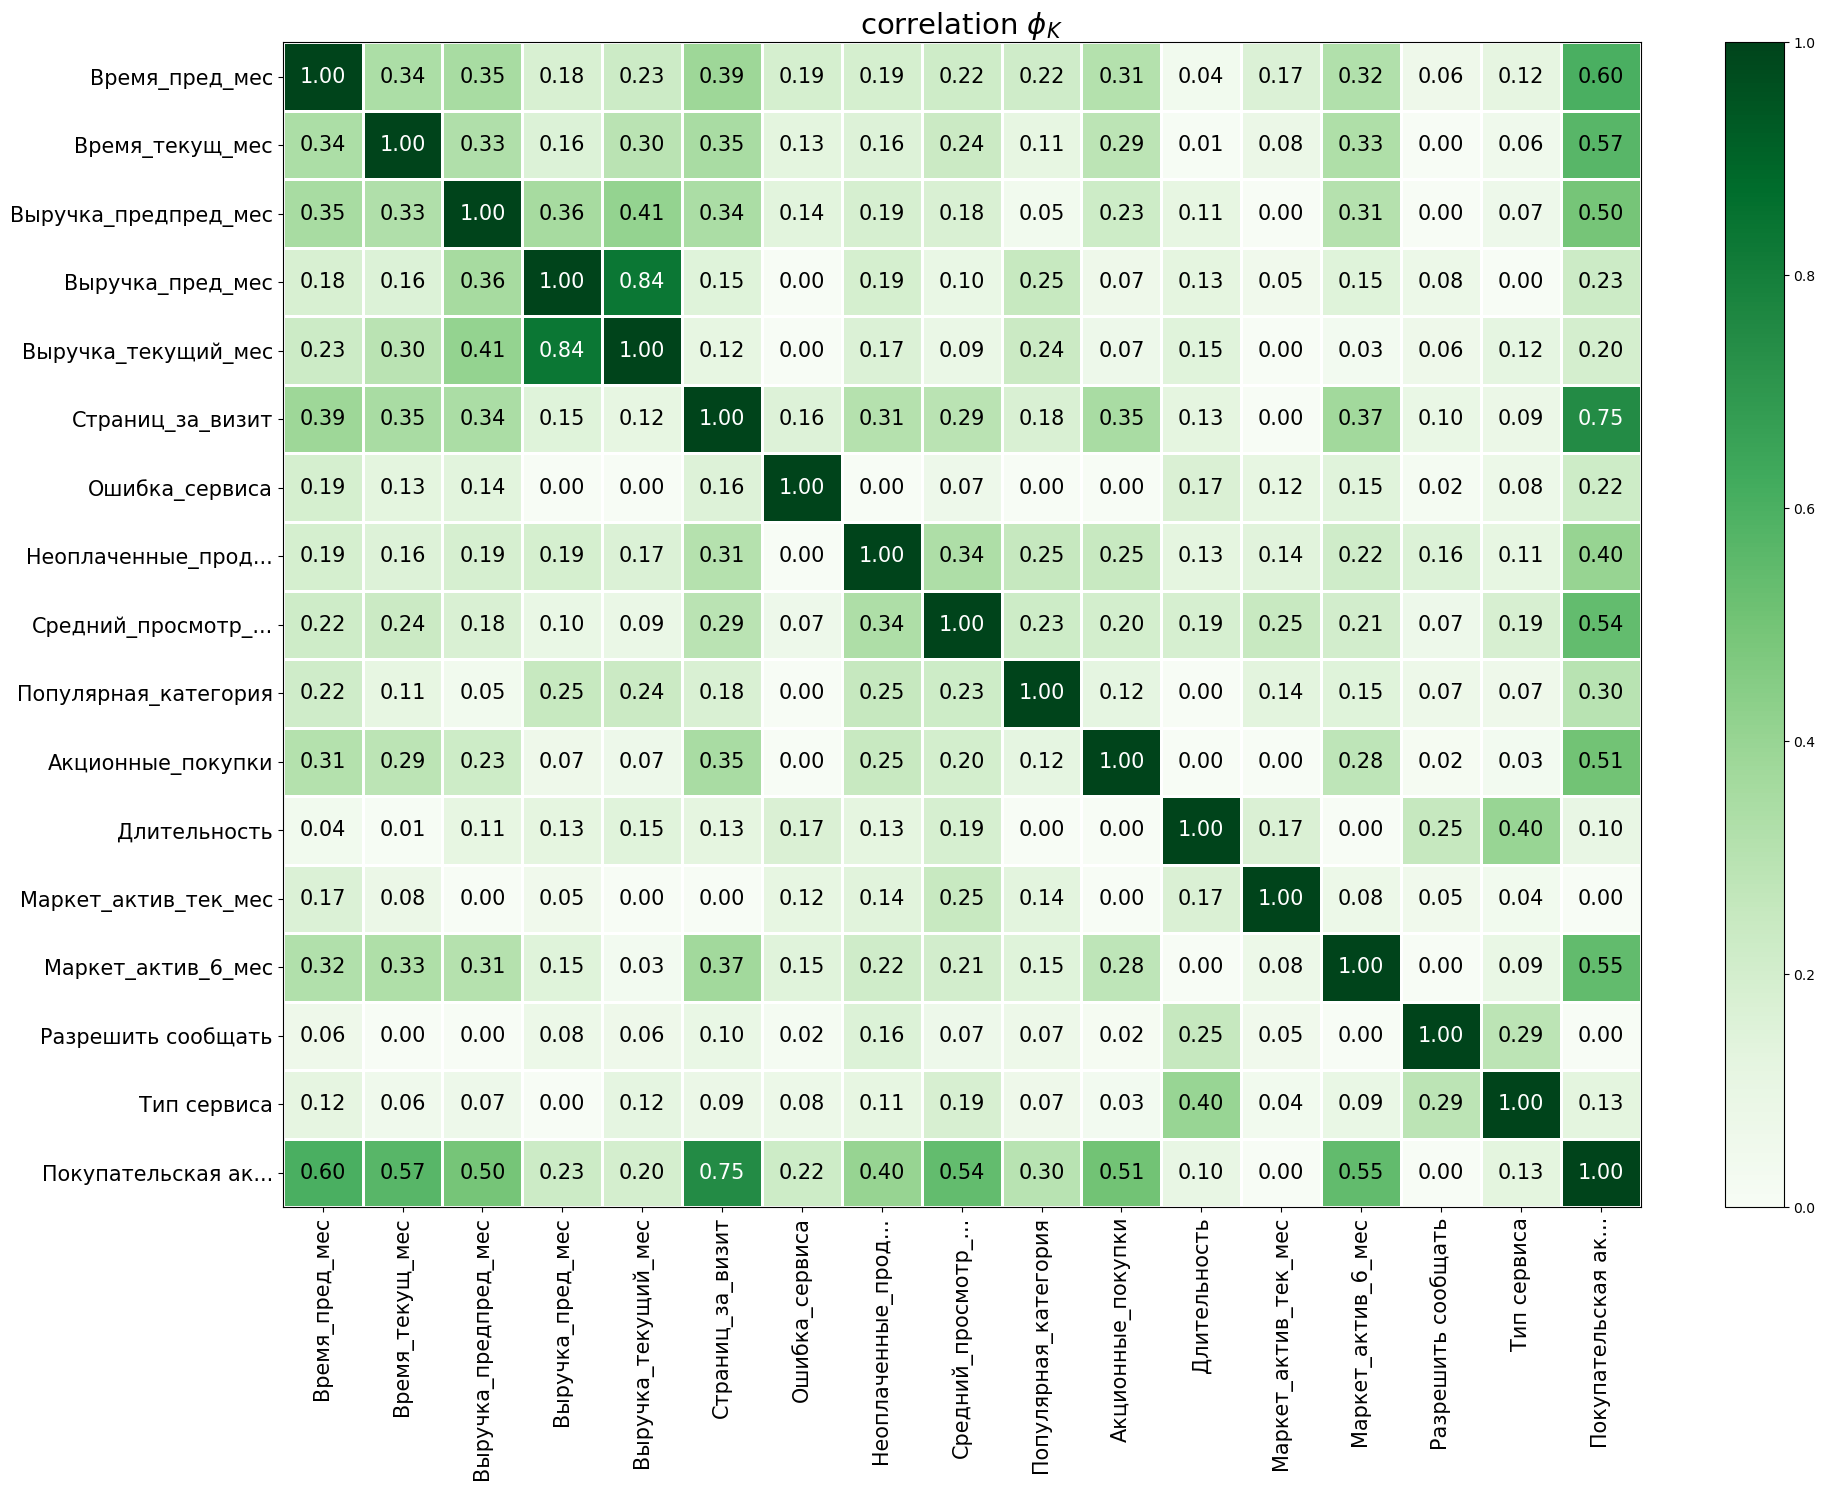

In [173]:
# считаем корреляции на тренировочной выборке
phik_overview = phik_matrix(df_market_file,interval_cols=interval_cols)

plot_correlation_matrix( phik_overview.values, x_labels=phik_overview.columns,y_labels=phik_overview.index,
                        vmin=0, vmax=1, 
                        color_map='Greens',
                        title=r'correlation $\phi_K$',
                        fontsize_factor=1.5, figsize=(20, 15))

**Выводы**

* Проведен корреляционный анализ таблицы для моделирования.
* Значительная корреляция наблюдается между целевым признаком и признаками "Просмотренных страниц за визит", "Время проведённое в предыдущем месяце", "Время проведенное в текущем месяце". Однако таких значений корреляции недостаточно, чтобы говорить о необходимости устранения этих признаков.
* Высокая корреляция наблюдается между двумя входными признаками "Выручка текущий месяц","Выручка предыдущий месяц". Однако значение коэффициента корреляции мало, для того, чтобы можно было говорить о мультиколлинеарности.

## Использование пайплайнов

Выделим количественные и категориальные признаки из таблицы. Среди категориальных выделим ранговые. Опишем переменные требующие кодирование

In [174]:
df_market_file.head()

,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_текущий_мес,Выручка_пред_мес,Выручка_предпред_мес,Время_текущ_мес,Время_пред_мес
id,,,,,,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4971.6,5216.0,4472.0,10,12
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5058.4,5457.5,4826.0,13,8
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6610.4,6158.0,4793.0,13,11
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5872.5,5807.5,4594.0,11,8
215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5388.5,4738.5,5124.0,10,10


In [175]:
sorted(list(df_market_file['Популярная_категория'].unique()))

['Домашний текстиль',
 'Косметика и аксессуары',
 'Кухонная посуда',
 'Мелкая бытовая техника и электроника',
 'Техника для красоты и здоровья',
 'Товары для детей']

### Подготовка пайплайнов

Количественные признаки:

* Маркет_актив\_6_мес
* Длительность
* Акционные_покупки
* Выручка_текущий_мес
* Выручка_пред_мес
* Выручка_предпред_мес

Требуют масштабирования

Категориальные признаки:

* Покупательская активность - целевой признак (бинарный)
* Тип сервиса - бинарный
* Разрешить сообщать - бинарный
* Популярная_категория - 6 категорий

Требуют кодирования

Категориальные порядковые признаки:

* 'Маркет_актив_тек_мес'
* 'Средний_просмотр_категорий_за_визит'
* 'Неоплаченные_продукты_штук_квартал'
* 'Ошибка_сервиса'
* 'Страниц_за_визит'
* 'Время_текущ_мес'
* 'Время_пред_мес'

Требуют кодирования

Запишем названия столбцов

In [176]:
num_columns = ['Маркет_актив_6_мес','Длительность','Акционные_покупки',
               'Выручка_текущий_мес','Выручка_пред_мес','Выручка_предпред_мес']


ohe_columns = ['Популярная_категория']

ord_columns = ['Тип сервиса','Разрешить сообщать']


Разделим данные

In [177]:
RANDOM_STATE = 42

X = df_market_file.drop(columns=['Покупательская активность'])
y = df_market_file['Покупательская активность'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y)

Закодируем целевой признак

In [178]:
label_encoder = LabelEncoder()


label_encoder.fit(y_train) 
print(y_train[:5])
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)
y_train[:5]

id
215858    Прежний уровень
215361          Снизилась
215884    Прежний уровень
216563    Прежний уровень
215714          Снизилась
Name: Покупательская активность, dtype: object


array([0, 1, 0, 0, 1])

LabelEncoder закодировл целевую переменную следующим образом

* Прежний уровень - 0
* Снизилась - 1

Напишем пайплайн подготовки данных, в котором будут операции по масштабированию количественных признаков и кодированию категориальных данных

Создадим список значений для кодирования порядковых признаков.

In [179]:
data_preprocessor = ColumnTransformer([('ohe', OneHotEncoder(drop='first',handle_unknown='ignore'), ohe_columns), 
                                       ('num', StandardScaler(), num_columns),
                                      ('ord', OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=np.nan),ord_columns)], 
                                      remainder='passthrough' )

Создадим список словарей, содержащий информацию о перебираемых моделях

Для моделирования будем использовать 4 модели

* Логистическая регрессия
* Метод опорных векторов
* Дерево решений
* Метод К-ближайших соседей

Будем использовать различные параметры моделей.
Масштабировать количественные данные будем с помощью двух методов: StandartScalar, MinMaxScalar

Кодировать категориальные признаки будем с помощью двух кодировщиков: OneHotEncoder, OrdinalEncoder


In [180]:
param_distributions = [
    # словарь для модели KNeighborsClassifier() 
    {
        # название модели
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'], 
    },
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 20),
        'models__min_samples_split': range(2, 10),
        'models__min_samples_leaf':range(2,10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'], 
    },
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE,probability=True)],
        'models__kernel': ['linear','rbf','sigmoid'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],

    },
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE,penalty = 'l1',solver='liblinear',class_weight='balanced')],
        'models__C':[0.1,0.2,0.3,0.5,1,5,10,20],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    }
] 

Подготовим финальный пайплайн, содержащий подготовку данных и обучение модели

In [181]:
pipe_final = Pipeline([ ('preprocessor', data_preprocessor),
                        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))])

### Поиск наилучшей модели

Для нахождения наилучшей модели будем использовать рандомизированный поиск.

Для оценика качества модели будем использовать метрику roc_auc, так как она не зависит от порога классификации модели.

In [182]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_distributions, 
    scoring='roc_auc', 
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter=100
)
randomized_search.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('\nМетрика лучшей модели на кросс-валидации выборке:', round(randomized_search.best_score_,2))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Популярная_категория']),
                                                 ('num', MinMaxScaler(),
                                                  ['Маркет_актив_6_мес',
                                                   'Длительность',
                                                   'Акционные_покупки',
                                                   'Выручка_текущий_мес',
                                                   'Выручка_пред_мес',
                                                   'Выручка_предпред_мес']),
                                                 ('ord',
         

Лучшей моделью оказалась взвешенная модель логистической регрессии с параметрами C=0.2 и регуляризацией l1.

In [183]:
X_train_new = randomized_search.best_estimator_.named_steps['preprocessor'].transform(X_train)
X_test_new = randomized_search.best_estimator_.named_steps['preprocessor'].transform(X_test)
X_train_new = pd.DataFrame(X_train_new,columns=randomized_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out())
X_test_new = pd.DataFrame(X_test_new,columns=randomized_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out())

model = randomized_search.best_estimator_.named_steps['models']
model.fit(X_train_new,y_train)

,penalty,'l1'
,dual,False
,tol,0.0001
,C,0.2
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'liblinear'
,max_iter,100
,multi_class,'deprecated'


In [184]:
y_pred = model.predict(X_test_new)
print(f'Значение метрики accuracy на тестовой выборке {round(accuracy_score(y_test,y_pred),2)}')

Значение метрики accuracy на тестовой выборке 0.86


In [185]:
y_pred_prob = model.predict_proba(X_test_new)
print(f'Значение метрики roc-auc на тестовой выборке {round(roc_auc_score(y_test,y_pred_prob[:,1]),2)}')

Значение метрики roc-auc на тестовой выборке 0.92


**Выводы**

* С помощью метода рандомизированного поиска была найдена модель дающее наилучшее значение метрика "roc_auc"
* Наилучшей моделью оказалась модель логистической регрессии
* Лучшее значение метрики roc_auc на кросс-валидации составило 0.89
* Лучшее значение метрики roc_auc на тестовой выборке составило 0.92
* Лучшее значение метрики accuracy на тестовой выборке составило 0.86

**Проверка на адекватность**

In [186]:
dummy_model = DummyClassifier(random_state=RANDOM_STATE,strategy='most_frequent')

In [187]:
dummy_model.fit(X_train_new, y_train)

,strategy,'most_frequent'
,random_state,42
,constant,None


In [188]:
y_pred = dummy_model.predict(X_test_new)
print(f'Значение метрики accuracy на тестовой выборке {round(accuracy_score(y_test,y_pred),2)}')

Значение метрики accuracy на тестовой выборке 0.62


In [189]:
y_pred_prob = dummy_model.predict_proba(X_test_new)
print(f'Значение метрики roc_auc на тестовой выборке {round(roc_auc_score(y_test,y_pred_prob[:,1]),2)}')

Значение метрики roc_auc на тестовой выборке 0.5


Проверка на адекватность показала, что качество полученной модели значительно превышает качество модели с константным предсказанием целевого признака

## Анализ важности признаков

Проанализируем важность признаков с помощью SHAP графиков.

Подготовим данные для построения

In [190]:
X_train_new = randomized_search.best_estimator_.named_steps['preprocessor'].transform(X_train)
X_test_new = randomized_search.best_estimator_.named_steps['preprocessor'].transform(X_test)
X_train_new = pd.DataFrame(X_train_new,columns=randomized_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out())
X_test_new = pd.DataFrame(X_test_new,columns=randomized_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out())


model = randomized_search.best_estimator_.named_steps['models']
model.fit(X_train_new,y_train)

,penalty,'l1'
,dual,False
,tol,0.0001
,C,0.2
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'liblinear'
,max_iter,100
,multi_class,'deprecated'


Построим график shap.plots.beeswarm

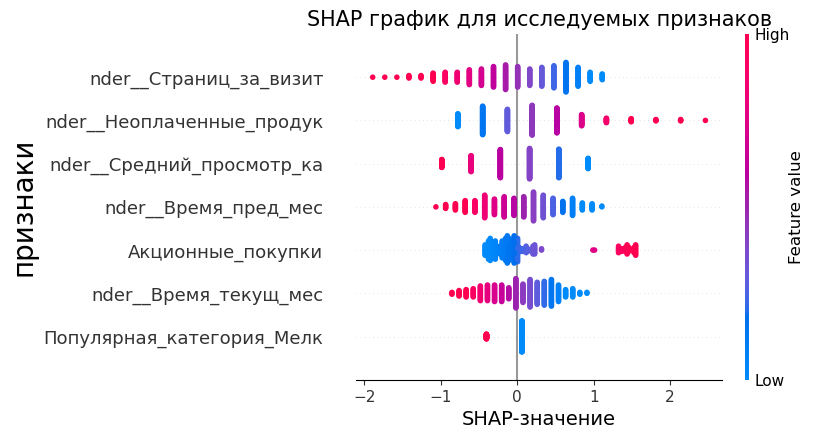

In [191]:
explainer = shap.LinearExplainer(model, X_train_new)

shap_values = explainer(X_test_new)


fig, ax = plt.gcf(), plt.gca()
feat_names = [i[5:30] for i in X_train_new]
shap.summary_plot(shap_values, show=False,max_display=7,feature_names=feat_names)
ax.set_title('SHAP график для исследуемых признаков', fontdict={"size":15})
ax.set_xlabel("SHAP-значение", fontsize=14)
ax.set_ylabel("признаки", fontsize=20)
plt.show()

На графике видно, что на целевой признак больше всего влияют категории:

* "Страниц за визит" - низкие значения  - больше вероятность снижения покупательской активности

* "Неоплаченные продукты штук квартал" - высокие значения - больше вероятность снижения покупательской активности

* "Средний просмотри категорий" - низкие значение - больше вероятность снижения покупательской активности

* "Акционные покупки" - Высокие значения - больше вероятность снижения покупательской активности

* "Время на сайте в предыдущем месяце" - низкие значения - больше вероятность снижения покупательской активности

* "Время на сайте в текущем месяце" - низкие значения - больше вероятность снижения покупательской активности


Мало значимые категории:

* Маркетинговая активность тек месяц
* Выручка предпредыдущий месяц
* Маркетинговая активность 6 мес
* 'Разрешить сообщать'
* 'Длительность'
* 'Ошибка_сервиса'
* 'Выручка_текущий_мес'
* 'Выручка_пред_мес'
* 'Тип сервиса'

Построим график shap.plots.bar

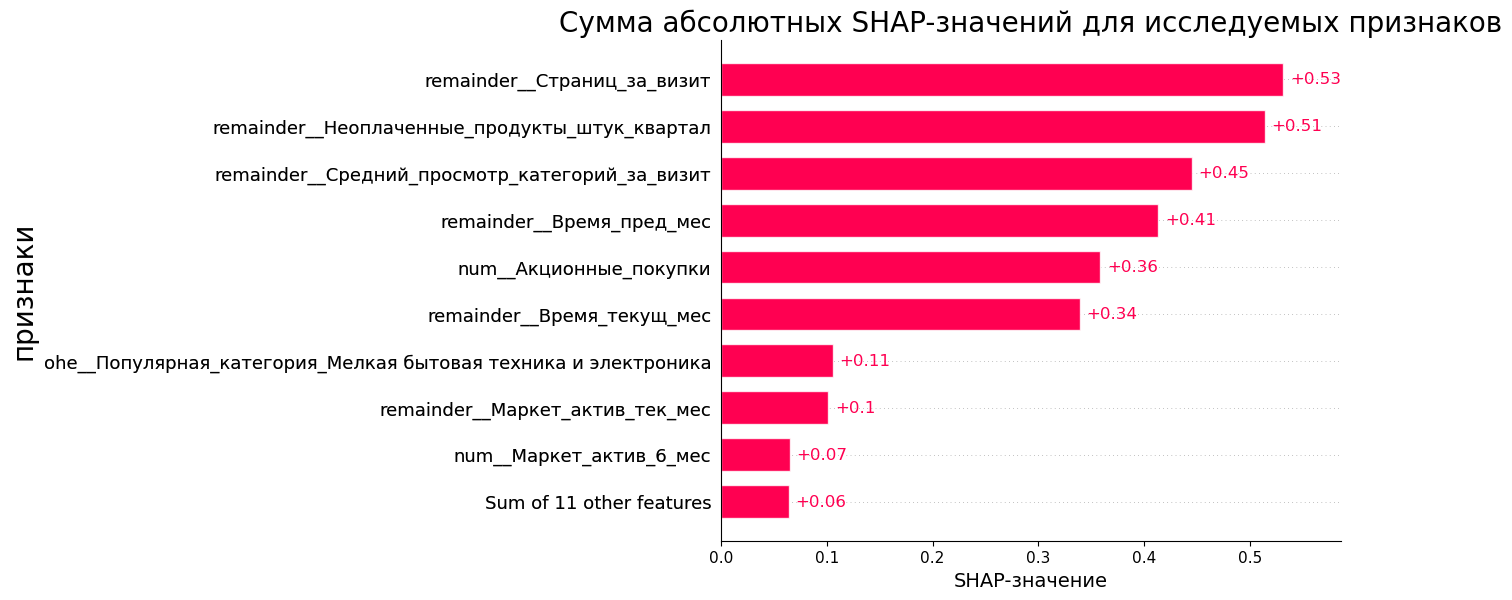

In [192]:
fig, ax = plt.gcf(), plt.gca()

shap.plots.bar(shap_values,show=False)
ax.set_title('Сумма абсолютных SHAP-значений для исследуемых признаков', fontdict={"size":20})
ax.set_xlabel("SHAP-значение", fontsize=14)
ax.set_ylabel("признаки", fontsize=20)
plt.show()

**Выводы**

При исследовании значимости признаков модели были выявлены признаки больше всего сказывающиеся на покупательской активности

* "Страниц за визит" - низкие значения  - больше вероятность снижения покупательской активности

* "Неоплаченные продукты штук квартал" - высокие значения - больше вероятность снижения покупательской активности

* "Средний просмотры категорий" - низкие значение - больше вероятность снижения покупательской активности

* "Акционные покупки" - Высокие значения - больше вероятность снижения покупательской активности

* "Время на сайте в предыдущем месяце" - низкие значения - больше вероятность снижения покупательской активности

* "Время на сайте в текущем месяце" - низкие значения - больше вероятность снижения покупательской активности

Предложения по использыванию найденной информации при принятии бизнес решений:

* Самый важный признак - страниц за визит. Для того, чтобы уровень покупательской активности оставался на прежнем уровне необходимо повышать количество просмотренных за визит страниц покупателем. Для этого можно

* Необходимо снижать количество товаров в корзине пользователя. Для этого можно информировать его о скидках на товары, находящиеся в корзине. Такой подход поможет уменьшить количество товаров в корзине и, как следствие, повысит покупательскую активность.

* Необходимо увеличивать количество просмотренных категорий за визит пользователей и их время проведенное на сайте. Для этого можно использовать алгоритмы рекомендаций, чтобы показывать пользователям страницы или товары, которые могут их заинтересовать, на основе их предыдущих действий.

## Сегментация данных

Используя данные моделирования выделим группу клиентов с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью.

Создадим датафрейм с предсказанной вероятностью снижения покупательской активности у клиента используя полученную модель.

In [193]:
clients_segment = pd.DataFrame(model.predict_proba(X_test_new)[:,1],columns=['Вероятность_снижения'],index=X_test.index)
clients_segment.head()

,Вероятность_снижения
id,
216446,0.700991
215469,0.690792
216301,0.114212
215713,0.837909
215500,0.885371


Объединим полученную таблицу с таблицей о прибыли

In [194]:
df_segment = clients_segment.join(df_money,how='inner')

Построим график зависимости вероятности снижения покупательской активности предсказанной моделью от прибыли, которую приносит покупатель

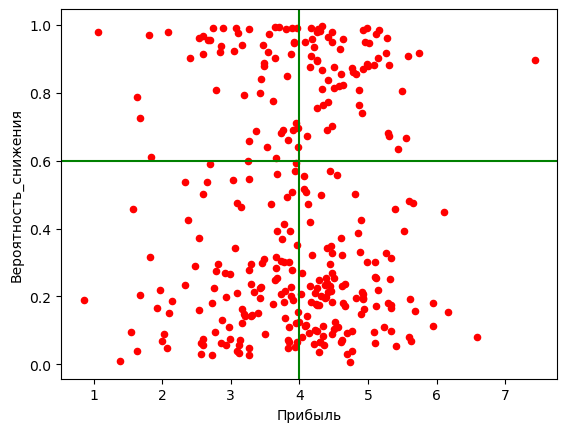

In [195]:
ax = df_segment.plot.scatter(x='Прибыль',y='Вероятность_снижения',color='r')
plt.axhline(y=0.6, color='g', linestyle='-')
plt.axvline(x=4, color='g', linestyle='-')
plt.show()

Разделим график на 4 сегмента. В правом верхнем углу будут покупатели с высокой вероятностью снижения покупательской активности принсоящие при этом высокую прибыль.

Выделим этих людей в отдельный датасет

In [196]:
clients = list(df_segment.query('Прибыль >= 4 & Вероятность_снижения > 0.6').index)
not_clients = list(df_segment.query('~(Прибыль >= 4 & Вероятность_снижения > 0.6)').index)

Проведем графическое исследование сегмета покупателей с высокой вероятностью снижения покупателськой активности и высокой прибыльностью.

Будем анализировать признаки наиболее влияющие на снижение покупательской активности.

* Страниц за визит
* Неоплаченные товары в корзине
* Средний просмотр категорий за визит
* Время в текущем месяце
* Время в предыдущем месяце

In [197]:
clients_target = X_test.loc[clients]
clients_not_target = X_test

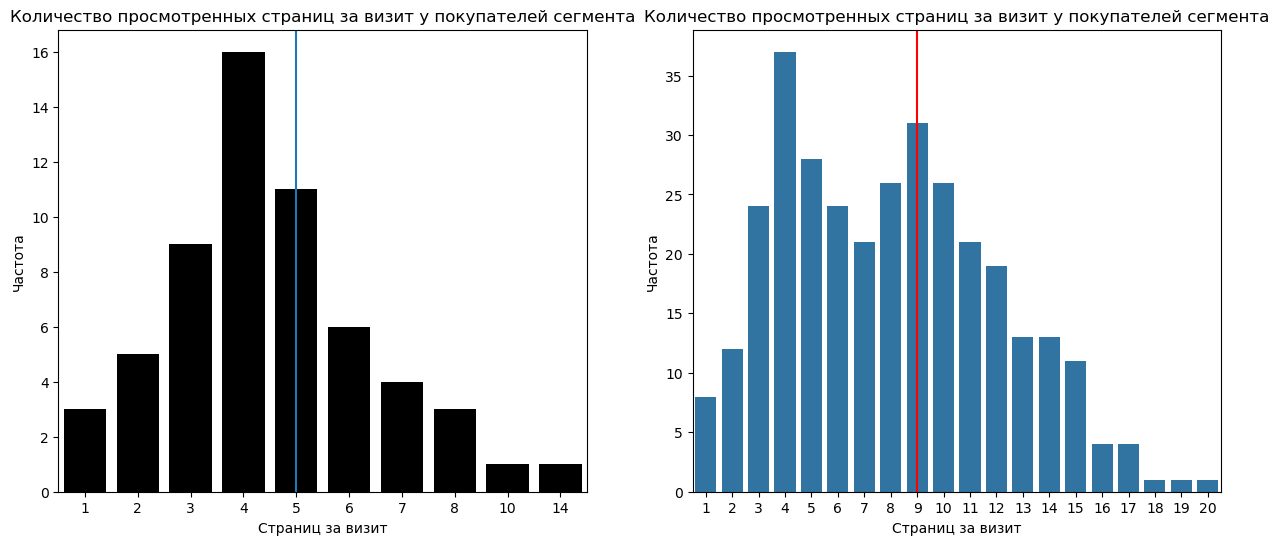

In [211]:
# Создаем фигуру и два подграфика
fig, ax = plt.subplots(1, 2, figsize=(15, 6))  # 1 строка, 2 колонки

sns.countplot(data=clients_target, x="Страниц_за_визит",ax=ax[0],color='black')
ax[0].set_title('Количество просмотренных страниц за визит у покупателей сегмента')
ax[0].axvline(clients_target['Страниц_за_визит'].median())
ax[0].set_xlabel('Страниц за визит')
ax[0].set_ylabel('Частота')


sns.countplot(data=clients_not_target, x="Страниц_за_визит",ax=ax[1])
ax[1].set_title('Количество просмотренных страниц за визит у покупателей сегмента')
ax[1].axvline(clients_not_target['Страниц_за_визит'].median(),color='r')
ax[1].set_xlabel('Страниц за визит')
ax[1].set_ylabel('Частота')
plt.show()

Распределение признака "Количество страниц, просмотренных пользователем за визит", среди пользователей выделенного сегмента показывает, что они в среднем просматривают меньше страниц, чем пользователи, не входящие в этот сегмент.

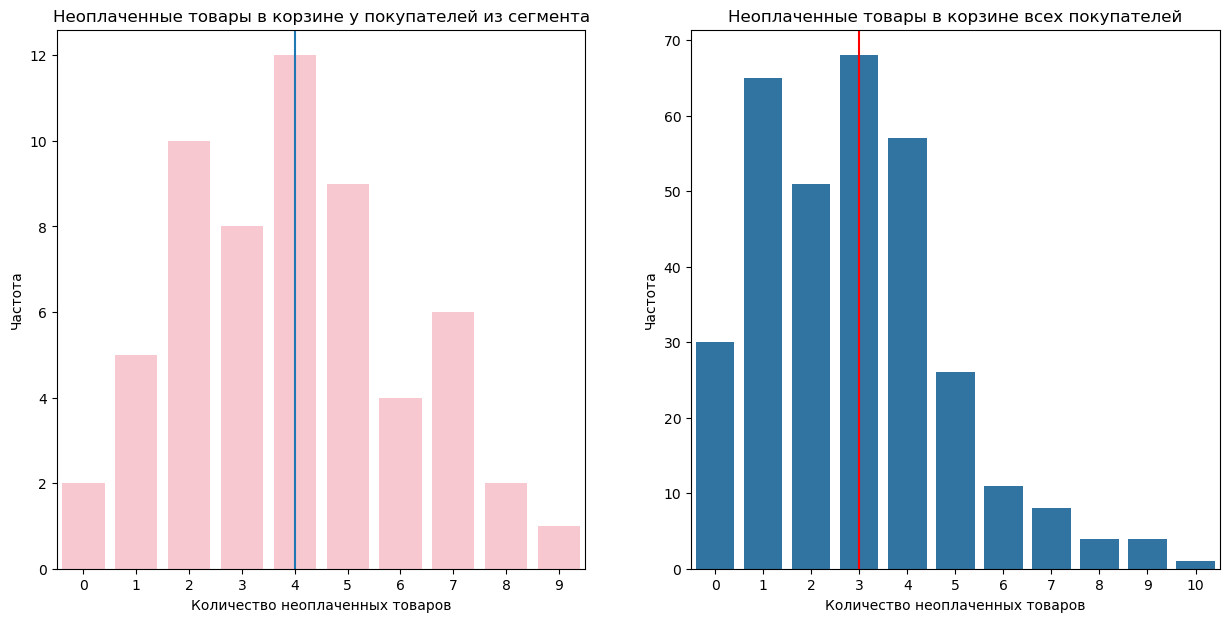

In [210]:
# Создаем фигуру и два подграфика
fig, ax = plt.subplots(1, 2, figsize=(15, 7))  # 1 строка, 2 колонки


sns.countplot(data=clients_target, x="Неоплаченные_продукты_штук_квартал",ax=ax[0],color='pink')
ax[0].axvline(clients_target['Неоплаченные_продукты_штук_квартал'].median())
ax[0].set_title('Неоплаченные товары в корзине у покупателей из сегмента')
ax[0].set_xlabel('Количество неоплаченных товаров')
ax[0].set_ylabel('Частота')


sns.countplot(data=clients_not_target, x="Неоплаченные_продукты_штук_квартал",ax=ax[1])
ax[1].axvline(clients_not_target['Неоплаченные_продукты_штук_квартал'].median(),color='r')
ax[1].set_title('Неоплаченные товары в корзине всех покупателей')
ax[1].set_xlabel('Количество неоплаченных товаров')
ax[1].set_ylabel('Частота')
plt.show()

Распределение признака "Количество неоплаченных товаров" среди пользователей выделенного сегмента показывает, что оно не имеет значительных отличий от распределения этого признака среди всех пользователей.

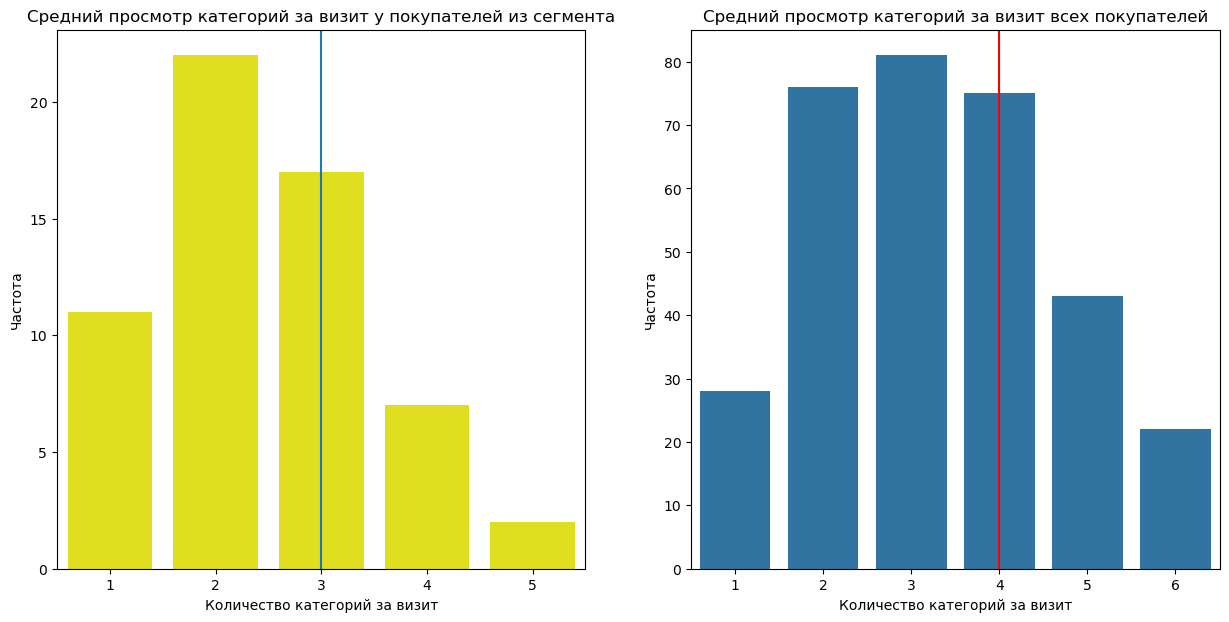

In [209]:
# Создаем фигуру и два подграфика
fig, ax = plt.subplots(1, 2, figsize=(15, 7))  # 1 строка, 2 колонки


sns.countplot(data=clients_target, x="Средний_просмотр_категорий_за_визит",ax=ax[0],color='yellow')
ax[0].axvline(clients_target['Средний_просмотр_категорий_за_визит'].median())
ax[0].set_title('Средний просмотр категорий за визит у покупателей из сегмента')
ax[0].set_xlabel('Количество категорий за визит')
ax[0].set_ylabel('Частота')


sns.countplot(data=clients_not_target, x="Средний_просмотр_категорий_за_визит",ax=ax[1])
ax[1].axvline(clients_not_target['Средний_просмотр_категорий_за_визит'].median(),color='r')
ax[1].set_title('Средний просмотр категорий за визит всех покупателей')
ax[1].set_xlabel('Количество категорий за визит')
ax[1].set_ylabel('Частота')
plt.show()

Среди пользователей сегмента нет покупателей, которые просматривают 6 категорий за визит. Покупатели в данном сегменте склонны просматривать меньшее количество категорий по сравнению с обычными пользователями.

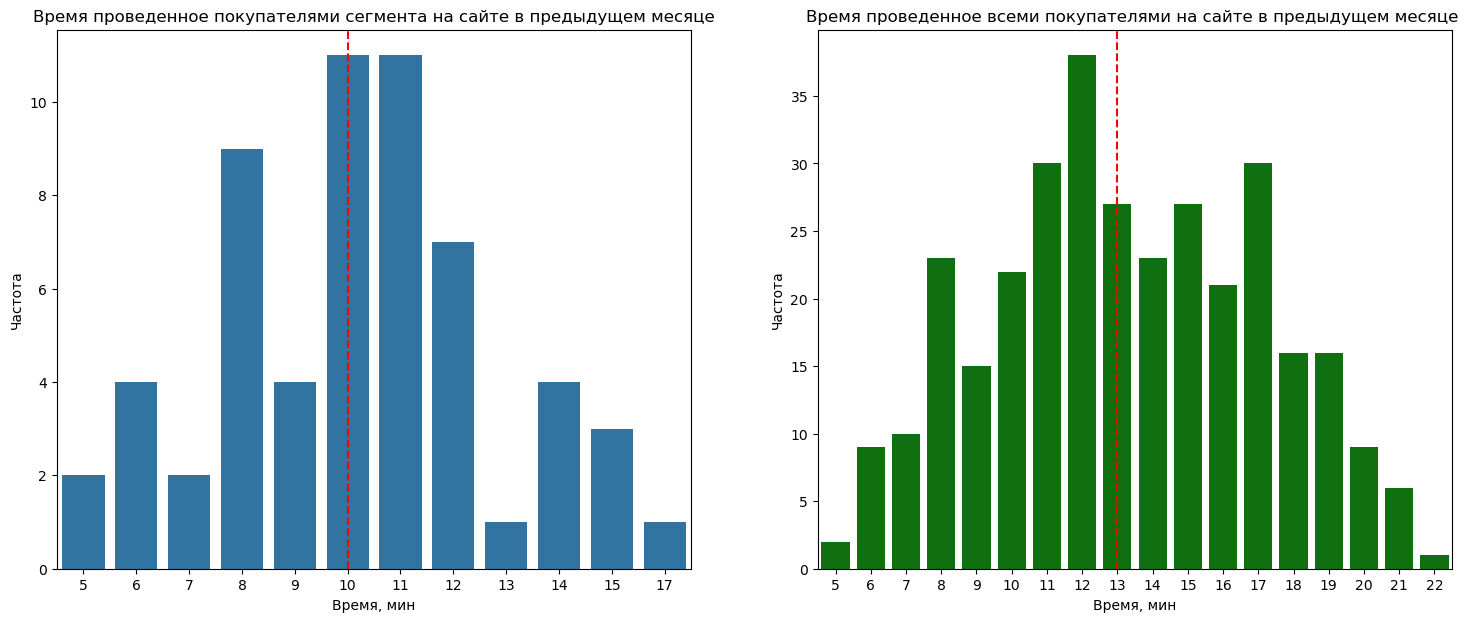

In [208]:
# Создаем фигуру и два подграфика
fig, ax = plt.subplots(1, 2, figsize=(18, 7))  # 1 строка, 2 колонки

sns.countplot(data=clients_target, x="Время_пред_мес",ax=ax[0])
ax[0].set_title('Время проведенное покупателями сегмента на сайте в предыдущем месяце')
ax[0].axvline(-clients_target["Время_пред_мес"].min() + clients_target["Время_пред_мес"].median(), color='red', linestyle='--')
ax[0].set_xlabel('Время, мин')
ax[0].set_ylabel('Частота')


sns.countplot(data=clients_not_target, x="Время_пред_мес",ax=ax[1],color='green')
ax[1].axvline(-clients_not_target["Время_пред_мес"].min() + clients_not_target["Время_пред_мес"].median(), color='red', linestyle='--')
ax[1].set_title('Время проведенное всеми покупателями на сайте в предыдущем месяце ')
ax[1].set_xlabel('Время, мин')
ax[1].set_ylabel('Частота')
plt.show()

Диаграммы постоенные по признаку Время проведенное покупателями на сайте в предыдущем месяце, показывает, что покупатели из рассматриваемого сегмента склонны проводить меньше времени на сайте

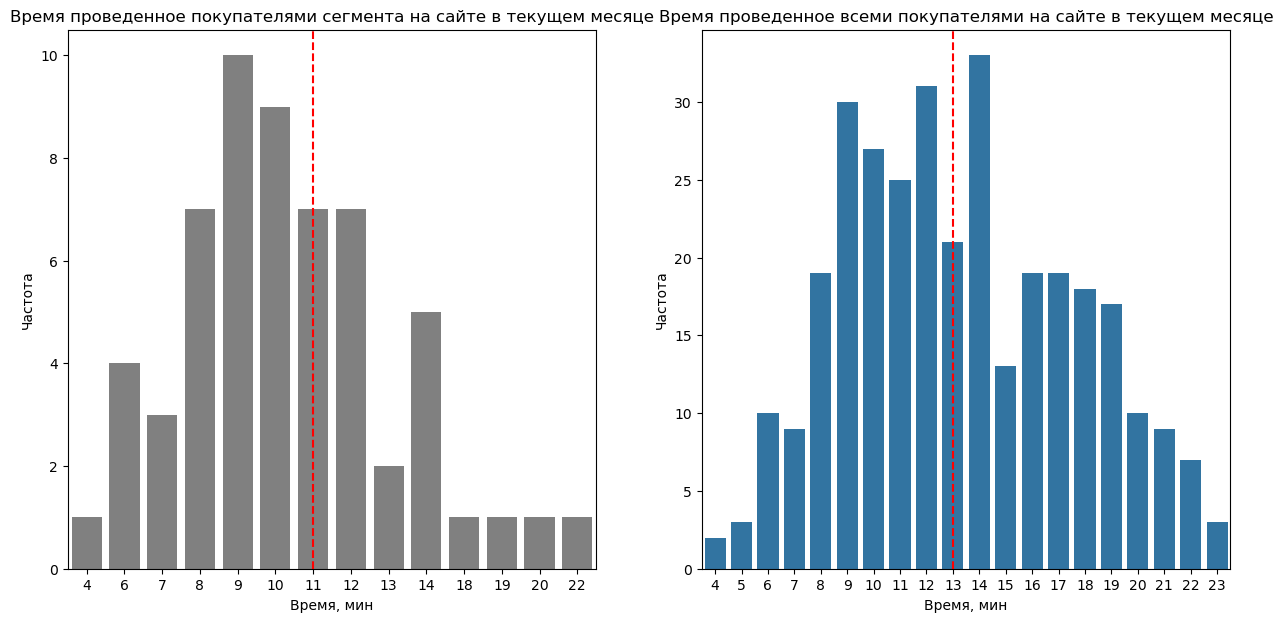

In [213]:
# Создаем фигуру и два подграфика
fig, ax = plt.subplots(1, 2, figsize=(15, 7))  # 1 строка, 2 колонки


sns.countplot(data=clients_target, x="Время_текущ_мес",ax=ax[0],color='grey')
ax[0].set_title('Время проведенное покупателями сегмента на сайте в текущем месяце')
ax[0].axvline(-clients_target["Время_текущ_мес"].min() + clients_target["Время_текущ_мес"].median(), color='red', linestyle='--')
ax[0].set_xlabel('Время, мин')
ax[0].set_ylabel('Частота')

sns.countplot(data=clients_not_target, x="Время_текущ_мес",ax=ax[1])
ax[1].axvline(-clients_not_target["Время_текущ_мес"].min() + clients_not_target["Время_текущ_мес"].median(), color='red', linestyle='--')
ax[1].set_title('Время проведенное всеми покупателями на сайте в текущем месяце')
ax[1].set_xlabel('Время, мин')
ax[1].set_ylabel('Частота')
plt.show()

Диаграммы постоенные по признаку Время проведенное покупателями на сайте в текущем месяце, показывает, что покупатели из рассматриваемого сегмента склонны проводить меньше времени на сайте

**Вывод**

Был выделен сегмент для исследования:  группа клиентов с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью. 

* Пользователи выделенного сегмента в среднем просматривают меньше страниц, чем пользователи, не входящие в этот сегмент.
* Было выявлено, что время проведенное на сайте для покупателей данного сегмента ниже, чем для остальных пользователей.
* Было выявлено, что пользователи этого сегмента проматривают меньше категорий за визит

**Рекомендации**

* Персонализированные рекомендации для пользователей данного сегмента могут стимулировать их проводить больше времени на сайте, что, в свою очередь, снизит вероятность уменьшения покупательской активности.
* Покупатели из этого сегмента просматривают мало категорий за визит. Эксклюзивные акционные предложения для данной группы из  пользователей поможет повысить количество просмотренных категорий пользователем за визит 
* Если показывать пользователям страницы с популярными товарами, новыми поступлениями или товарными группами, которые могут их заинтересовать, это приведет к увеличению количества просматриваемых страниц за визит, что, в свою очередь, позитивно скажется на их покупательской способности.

## Общий вывод

В результате проведённой работы были достигнуты следующие результаты

Этап 1: **Ознакомление с данными**. Первичное ознакомление со структурой данных.

Этап 2: **Предобработка данных**. В ходе предобработки данных из таблицы были проверены на наличие пропусков, дубликатов, неявных дубликатов. Были исправлены ошибки в данных, некоторые столбцы были приведены к корректному типу.

Этап 3: **Исследовательский анализ данных**.

   * Был проведён графический анализ все признаков в датасетах
   * Были устранены аномальные значения
   * Были отобраны покупатели, совершавшие покупки за последние три месяца
   
Этап 4: **Объединение данных**. Были объединены данные для последующего создания модели.

Этап 5: **Корреляционный анализ данных**
   * Проведен корреляционный анализ таблицы для моделирования
   * Мультиколлинеарности и утечки целевого признака не обнаружено

Этап 6: **Использование пайплайнов**

* С помощью метода рандомизированного поиска была найдена модель дающее наилучшее значение метрика "roc_auc"
* Наилучшей моделью оказалась модель логистической регрессии
* Лучшее значение метрики roc_auc на кросс-валидации составило 0.89
* Лучшее значение метрики roc_auc на тестовой выборке составило 0.92
* Лучшее значение метрики accuracy на тестовой выборке составило 0.86
   
Этап 7: **Анализ важности признаков**
При исследовании значимости признаков модели были выявлены признаки больше всего сказывающиеся на покупательской активности

* "Страниц за визит" - низкие значения  - больше вероятность снижения покупательской активности

* "Неоплаченные продукты штук квартал" - высокие значения - больше вероятность снижения покупательской активности

* "Средний просмотры категорий" - низкие значение - больше вероятность снижения покупательской активности

* "Акционные покупки" - Высокие значения - больше вероятность снижения покупательской активности

* "Время на сайте в предыдущем месяце" - низкие значения - больше вероятность снижения покупательской активности

* "Время на сайте в текущем месяце" - низкие значения - больше вероятность снижения покупательской активности



Этап 8: **Сегментация данных**
    Был выделен сегмент для исследования:  группа клиентов с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью. 

* Пользователи выделенного сегмента в среднем просматривают меньше страниц, чем пользователи, не входящие в этот сегмент.
* Было выявлено, что время проведенное на сайте для покупателей данного сегмента ниже, чем для остальных пользователей.
* Было выявлено, что пользователи этого сегмента просматривают меньше категорий за визит



**Рекомендации бизнесу**

* Самый важный признак - страниц за визит. Для того, чтобы уровень покупательской активности оставался на прежнем уровне необходимо повышать количество просмотренных за визит страниц покупателем. Для этого можно

* Необходимо снижать количество товаров в корзине пользователя. Для этого можно информировать его о скидках на товары, находящиеся в корзине. Такой подход поможет уменьшить количество товаров в корзине и, как следствие, повысит покупательскую активность.

* Необходимо увеличивать количество просмотренных категорий за визит пользователей и их время проведенное на сайте. Для этого можно использовать алгоритмы рекомендаций, чтобы показывать пользователям страницы или товары, которые могут их заинтересовать, на основе их предыдущих действий.


**Рекомендации бизнесу по исследованному сегменту**

* Персонализированные рекомендации для пользователей данного сегмента могут стимулировать их проводить больше времени на сайте, что, в свою очередь, снизит вероятность уменьшения покупательской активности.
* Покупатели из этого сегмента просматривают мало категорий за визит. Эксклюзивные акционные предложения для данной группы из  пользователей поможет повысить количество просмотренных категорий пользователем за визит 
* Если показывать пользователям страницы с популярными товарами, новыми поступлениями или товарными группами, которые могут их заинтересовать, это приведет к увеличению количества просматриваемых страниц за визит, что, в свою очередь, позитивно скажется на их покупательской способности.